In [1]:
!pip install statsmodels pmdarima --quiet


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Standard libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Enhanced: JAX libraries
import jax.numpy as jnp
from jax import random

# Plotting options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\aryan\AppData\Local\Temp\ipykernel_36784\2325616350.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [16]:
import zipfile
import io
import requests

# Download the zipped dataset
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
response = requests.get(uri)

# Unzip and read the CSV file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("jena_climate_2009_2016.csv") as f:
        df = pd.read_csv(f, parse_dates=["Date Time"], dayfirst=True)

# Set timestamp as index
df = df.set_index("Date Time")
df.index = pd.to_datetime(df.index)

# Preview the dataset
print("Shape:", df.shape)
print(df.head())

Shape: (420551, 14)
                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-

C:\Users\aryan\AppData\Local\Temp\ipykernel_36784\500661740.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()


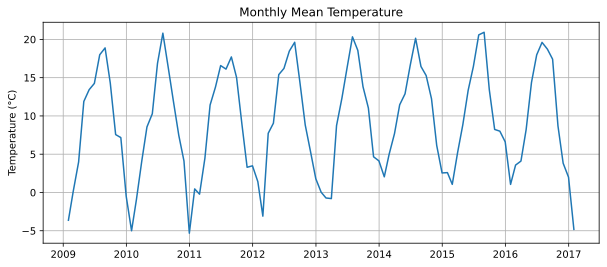

In [17]:
# Downsample to monthly means
monthly_df = df.resample('M').mean()

# Select temperature for SARIMA modeling
temperature = monthly_df["T (degC)"].dropna()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(temperature)
plt.title("Monthly Mean Temperature")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


In [18]:
split_index = int(len(temperature) * 0.8)
train, test = temperature[:split_index], temperature[split_index:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 77, Test size: 20


In [19]:
# Auto ARIMA model selection with seasonal=True and monthly seasonality (m=12)
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)

print(auto_model.summary())


Performing stepwise search to minimize aic


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: Futur

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=520.828, Time=0.04 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=401.852, Time=0.65 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=439.871, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=594.249, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=443.465, Time=0.08 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.05 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=384.385, Time=1.75 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=425.478, Time=0.48 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=386.269, Time=2.53 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=386.235, Time=1.98 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=416.815, Time=0.87 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=388.018, Time=3.27 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=389.405, Time=1.25 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=385.603, Time=2.03 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=385.663, Time=2.05 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=386.098, Time=1.84 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.81 sec


c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12]             : AIC=392.982, Time=0.95 sec

Best model:  ARIMA(1,0,0)(1,0,1)[12] intercept
Total fit time: 27.400 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   77
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -187.192
Date:                              Wed, 14 May 2025   AIC                            384.385
Time:                                      22:40:14   BIC                            396.104
Sample:                                  01-31-2009   HQIC                           389.072
                                       - 05-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [20]:
# Fit SARIMAX with selected parameters
model = SARIMAX(
    train,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = model.fit(disp=False)


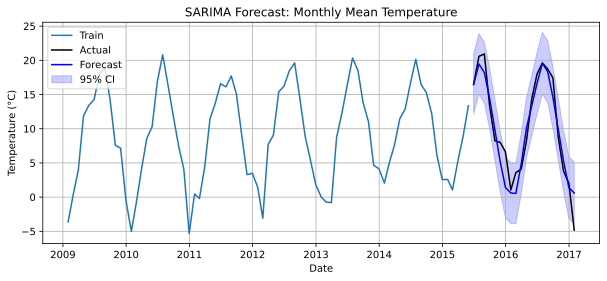

In [21]:
n_forecast = len(test)
forecast_result = sarima_result.get_forecast(steps=n_forecast)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual", color='black')
plt.plot(test.index, forecast_mean, label="Forecast", color='blue')
plt.fill_between(
    test.index, 
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1], 
    color='blue', 
    alpha=0.2, 
    label="95% CI"
)
plt.title("SARIMA Forecast: Monthly Mean Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# sMAPE function
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Evaluate
smape_val = smape(test.values, forecast_mean.values)
rmse_val = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"sMAPE: {smape_val:.2f}%")
print(f"RMSE: {rmse_val:.2f} °C")


sMAPE: 38.67%
RMSE: 2.29 °C
